In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import torch
from torch.nn import Module, Linear, Sigmoid, Sequential, ReLU, MSELoss
import torchvision
import matplotlib.pyplot as plt
from torch.optim import Adam
from util.dashboard import DashBoard

class VahidAutoencoder(Module):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential(
            Linear(28*28, 128),
            Linear(128, 28*28),
            ReLU(),
            Linear(28*28, 64),
            Linear(64, 28*28),
            ReLU(),
            Linear(28*28, 2),
        )
        self.decoder = Sequential(
            Linear(2, 28*28),
            ReLU(),
            Linear(28*28, 64),
            Linear(64, 28*28),
            ReLU(),
            Linear(28*28, 128),
            Linear(128, 28*28),
            Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def train_step(self, x, optimizer):
        optimizer.zero_grad()
        y = self(x)
        #print(y.shape, x.shape)
        loss = torch.mean((y - x)**2)
        loss.backward()
        optimizer.step()
        return loss.item()
    
class ClassicAutoencoder(Module):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential(
            Linear(28*28, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 2),
        )
        self.decoder = Sequential(
            Linear(2, 64),
            ReLU(),
            Linear(64, 128),
            ReLU(),
            Linear(128, 28*28),
            Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def train_step(self, x, optimizer):
        optimizer.zero_grad()
        y = self(x)
        #print(y.shape, x.shape)
        loss = torch.mean((y - x)**2)
        loss.backward()
        optimizer.step()
        return loss.item()
    

In [2]:
data = torchvision.datasets.MNIST(root='./data', train=True, download=True).data

Epoch 0 Loss 0.06554904580116272
Epoch 10 Loss 0.04739897698163986
Epoch 20 Loss 0.043632470071315765
Epoch 30 Loss 0.03402591496706009
Epoch 40 Loss 0.03610146790742874
Epoch 50 Loss 0.031894948333501816
Epoch 60 Loss 0.0286624263972044
Epoch 70 Loss 0.023685768246650696
Epoch 80 Loss 0.02409449964761734
Epoch 90 Loss 0.022087877616286278
Epoch 100 Loss 0.021358348429203033
Epoch 110 Loss 0.0219273641705513
Epoch 120 Loss 0.018949203193187714
Epoch 130 Loss 0.018021417781710625
Epoch 140 Loss 0.018112951889634132
Epoch 150 Loss 0.01712643913924694
Epoch 160 Loss 0.016880959272384644
Epoch 170 Loss 0.014523553662002087
Epoch 180 Loss 0.013812460005283356
Epoch 190 Loss 0.014660727232694626


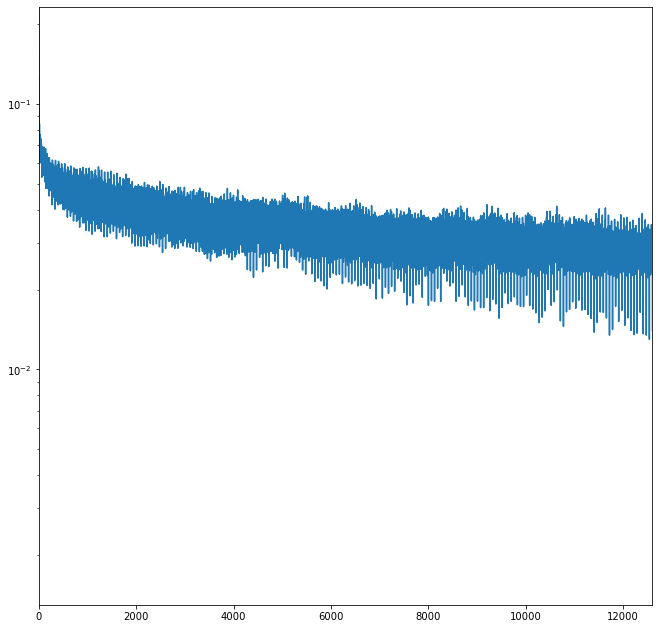

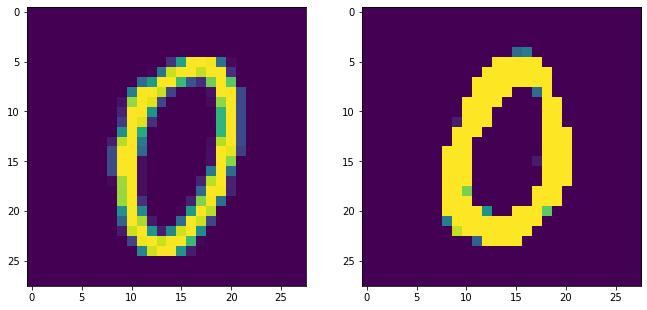

In [3]:
device = "cpu"
data = data.data.float().to(device) / 255
train = data[:1000]
test = data[1000:1000+100]
dash = DashBoard()


def ravel(x):
    return x.reshape(x.shape[0], -1)

def unravel(x):
    return x.reshape(x.shape[0], 28, 28)

ravel_train = ravel(train)
ravel_test = ravel(test)


net = VahidAutoencoder().to(device)
optim = Adam(net.parameters(), lr=1e-3)

N_EPOCHS = 200
BATCH_SIZE = 16

fig_loss = plt.figure(figsize=(11,11))
loss_plot = plt.plot([])
ax_loss = plt.gca()
losses = []
plt.yscale("log")

fig_example = plt.figure(figsize=(11,11))
plt.subplot(121)
plt.imshow(unravel(ravel_test[:1])[0].detach().cpu().numpy())
ax_example = plt.subplot(122)
example_plot = ax_example.imshow(unravel(net(ravel_test[:1]))[0].detach().cpu().numpy())


dash.add_figure(fig_loss)
dash.add_figure(fig_example)

for epoch in range(N_EPOCHS):
    for i in range(0, len(ravel_train), BATCH_SIZE):
        batch = ravel_train[i:i+BATCH_SIZE]
        loss = net.train_step(batch, optim)
        losses.append(loss)
    
    loss_plot[0].set_data(range(len(losses)), losses)
    ax_loss.set_xlim(0, len(losses))
    ax_loss.set_ylim(min(losses)/10, max(losses))  
    example_plot.set_data(unravel(net(ravel_test[:1]))[0].detach().cpu().numpy())
    
    dash.update_all()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss {loss}")

/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


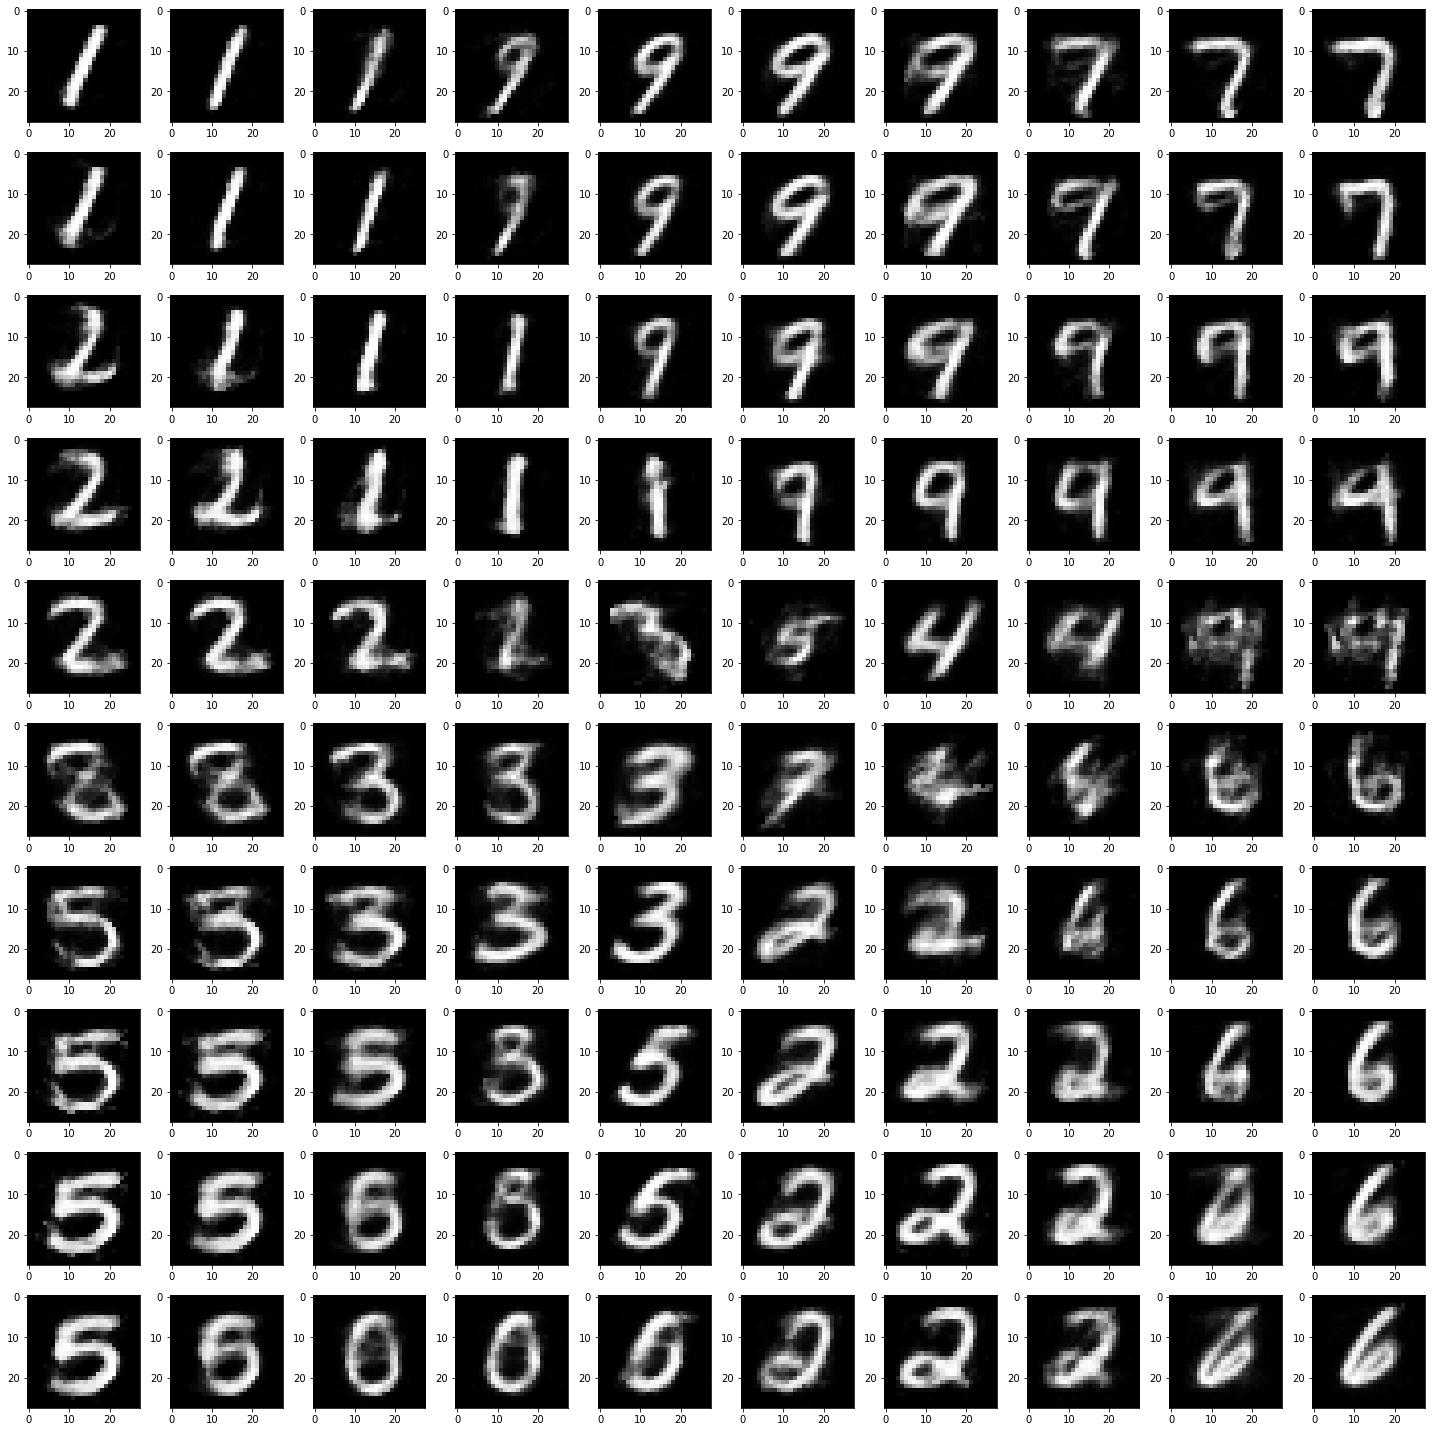

In [4]:
plt.figure(figsize=(20, 20))
n = 10
x = torch.linspace(-2, 2, n)
X, Y = torch.meshgrid(x, x)

for i, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
    out = net.decoder(torch.tensor([x, y]).float().to(device)[None, :]).view(28, 28).cpu().detach().numpy()
    plt.subplot(n, n, i+1)
    plt.imshow(out, cmap="gray")
    
plt.tight_layout()    

